# Исследование надежности заемщиков.

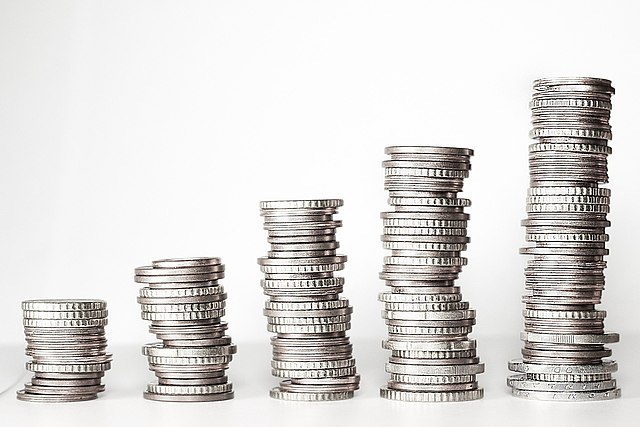

## Описание проекта
Имеются данные о клиентах банка, желающих взять кредит. По имеющимся данным необходимо оценить, влияют ли семейное положение и количество детей клиента на факт погашения кредита в срок.

Результаты исследования могут быть использованы при построении модели кредитного скоринга — системы, которая оценивает способность потенциального заёмщика вернуть кредит банку.

## Обзор данных

In [104]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [105]:
sns.set_style('darkgrid')
sns.set(rc={'figure.figsize': (15, 5)})

In [106]:
! gdown 15Vmg-LVhC0km5huaQ6QLNSn4cZlIix-a

Downloading...
From: https://drive.google.com/uc?id=15Vmg-LVhC0km5huaQ6QLNSn4cZlIix-a
To: /content/data_preprocessing.csv
100% 3.32M/3.32M [00:00<00:00, 189MB/s]


In [107]:
try:
    df = pd.read_csv('/content/data_preprocessing.csv')
except:
    print('Возникла проблема с файлом данных')

In [108]:
# мы загрузили данные, теперь надо посмотреть на них
# выведем первые пять строк, а потом общую информацию о таблице
display(df.head())
df.info()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,-5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,-4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21525 non-null  int64  
 1   days_employed     19351 non-null  float64
 2   dob_years         21525 non-null  int64  
 3   education         21525 non-null  object 
 4   education_id      21525 non-null  int64  
 5   family_status     21525 non-null  object 
 6   family_status_id  21525 non-null  int64  
 7   gender            21525 non-null  object 
 8   income_type       21525 non-null  object 
 9   debt              21525 non-null  int64  
 10  total_income      19351 non-null  float64
 11  purpose           21525 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


В таблице 21525 строк и 12 колонок. В них содержутся следующие данные:

* `children` — количество детей в семье
* `days_employed` — общий трудовой стаж в днях
* `dob_years` — возраст клиента в годах
* `education` — уровень образования клиента
* `education_id` — идентификатор уровня образования
* `family_status` — семейное положение
* `family_status_id` — идентификатор семейного положения
* `gender` — пол клиента
* `income_type` — тип занятости
* `debt` — имел ли задолженность по возврату кредитов
* `total_income` — ежемесячный доход
* `purpose` — цель получения кредита

## Обработка
### Заполнение пропусков

Посмотрим, есть ли в таблице пропуски и в каких колонках они встречаются:

In [109]:
# в таблице есть столбцы, содержащие пропуски данных. найдём их
df.isna().sum().to_frame()

,0
children,0
days_employed,2174
dob_years,0
education,0
education_id,0
family_status,0
family_status_id,0
gender,0
income_type,0
debt,0


In [110]:
na_share = 100 * df.loc[:,'total_income'].isna().mean()
print(f'Процент пропущенных значений в столбце total_income: {round(na_share, 1)}%')

Процент пропущенных значений в столбце total_income: 10.1%


В таблице пропуски содержатся в столбцах `days_employed` (общий трудовой стаж в днях) и `total_income` (ежемесячный доход). Пропущенные значения встречаются в 10% записей.

In [111]:
# проверка, что пропуски данных по столбцам days_employed и total_income содержаться в одних и тех же строках
df[df['days_employed'].isna() & df['total_income'].isna()].shape[0]

2174

Интересно, что все строки, содержащие пропуски, содержат их в обоих столбцах. Строк, содержащих пропуски только в одном из столбцов, нет.
Возможно пропуски данных связаны с тем, что клиенты не раскрывали информацию (стаж и доход), которая могла бы негативно повлиять на шанс выдачи кредита?

Заполним пропуски в столбце `total_income` медианным значением по столбцу.

In [112]:
# вычисляем медиану и заполняем ей пропуски в столбце total_income
t_income_median = df['total_income'].median()
# выводим медиану
print('Медиана:', round(t_income_median, 2))
df['total_income'] = df['total_income'].fillna(value=t_income_median)
# убедимся, что теперь в стобце больше нет пропусков
print('Количество пропусков после обработки:', df['total_income'].isna().sum())

Медиана: 145017.94
Количество пропусков после обработки: 0


### Проверка данных на аномалии и исправления

Пройдёмся по всем столбцам и попробуем заметить аномалии.

#### `children`

In [113]:
df['children'].unique()

array([ 1,  0,  3,  2, -1,  4, 20,  5])

In [114]:
print('Количество записей с полем children равным 20:', df[df['children'] == 20]['children'].count())
print('Количество записей с полем children равным -1:', df[df['children'] == -1]['children'].count())
# заполняем записи с ошибочными данными медианным значением
print('\nМедианное значение:', int(df['children'].median()))
df.loc[(df['children'] == 20) | (df['children'] == -1), 'children'] = int(df['children'].median())
# убедимся, что аномальных данных больше нет
df['children'].unique()

Количество записей с полем children равным 20: 76
Количество записей с полем children равным -1: 47

Медианное значение: 0


array([1, 0, 3, 2, 4, 5])

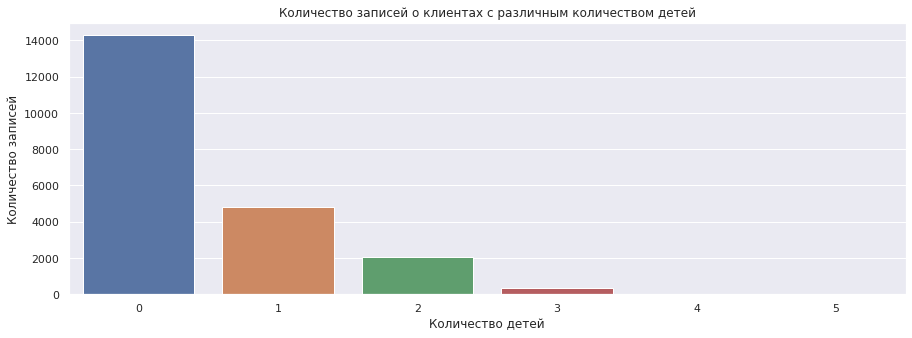

In [115]:
sns.countplot(data=df, x='children')\
.set(title='Количество записей о клиентах с различным количеством детей',
     xlabel='Количество детей',
     ylabel='Количество записей');

Видно, что в таблице содержались 76 записей со значением столбца `children` 20 и 47 записей с отрицательным значением столбца. Оба значения были похожи на ошибочные и мы заполнили их медианным значением. Возможные причины возникновения ошибок: человеческий фактор (ошибки при записи значений), технические ошибки. Можно было бы заполнить их значениями 2 и 1, но у нас нет никакой информации о том, какой способ был бы предпочтительнее

#### `days_employed`

In [116]:
df['days_employed'].head().to_frame()

,days_employed
0,-8437.673028
1,-4024.803754
2,-5623.422610
3,-4124.747207
4,340266.072047


Видно, что в столбце содержатся отрицательные значения. Посмотрим сколько их:

In [117]:
neg_days_count = df[df['days_employed'] < 0]['days_employed'].count()
print('\nКоличество отрицательных значений:', neg_days_count)
print(f'Процент от общего числа записей: {round(100 * neg_days_count / df.shape[0], 2)}%')


Количество отрицательных значений: 15906
Процент от общего числа записей: 73.9%


In [118]:
# посмотрим насколько различаются отрицательные и положительные данные
neg = df.loc[df['days_employed'] < 0, 'days_employed'].copy()
pos = df.loc[df['days_employed'] > 0, 'days_employed'].copy()
neg = neg.abs()
print('Диапазон взятых по модулю отрицательных значений:', round(neg.min(), 2), '-', round(neg.max(), 2))
print('Диапазон положительных значений', round(pos.min(), 2), '-', round(pos.max(), 2))

Диапазон взятых по модулю отрицательных значений: 24.14 - 18388.95
Диапазон положительных значений 328728.72 - 401755.4


Очевидно, что отрицательного трудового стажа не бывает. В рабочем проекте надо было бы выяснить причину возникновения подобных данных и устранить их. Так как сейчас это сделать не представляется возможным, можно решить проблему двумя способами:
1. заменить отрицательные значения на значения по модулю;
2. заменить медианным значением.

В любом случае у нас сохраняется проблема огомного разброса значений, с которым мы ничего не можем сделать без дополнительной информации.

Давайте пока просто заменим все значения на значения по модулю, на решении задачи это не скажется.

In [119]:
df.loc[:,'days_employed'] = df.loc[:,'days_employed'].abs()
# убедимся, что отрицательных значений не осталось:
df.loc[df['days_employed'] < 0,'days_employed'].shape[0]

0

#### `dob_years`

In [120]:
df['dob_years'].unique()

array([42, 36, 33, 32, 53, 27, 43, 50, 35, 41, 40, 65, 54, 56, 26, 48, 24,
       21, 57, 67, 28, 63, 62, 47, 34, 68, 25, 31, 30, 20, 49, 37, 45, 61,
       64, 44, 52, 46, 23, 38, 39, 51,  0, 59, 29, 60, 55, 58, 71, 22, 73,
       66, 69, 19, 72, 70, 74, 75])

Очевидно, что клиенту не может быть 0 лет, в данном случае вполне возможно использовать медианное значение. Данная ошибка могла возникнуть в результате опечатки (например, клиенту было 50 лет, но клавишу 5 не нажали).

In [121]:
dob_years_median = int(df.loc[df['dob_years'] != 0, 'dob_years'].median())
df.loc[df['dob_years'] == 0, 'dob_years'] = dob_years_median
# снова выводим значения столбца, чтобы убедиться в том, что всё исправили
df['dob_years'].unique()

array([42, 36, 33, 32, 53, 27, 43, 50, 35, 41, 40, 65, 54, 56, 26, 48, 24,
       21, 57, 67, 28, 63, 62, 47, 34, 68, 25, 31, 30, 20, 49, 37, 45, 61,
       64, 44, 52, 46, 23, 38, 39, 51, 59, 29, 60, 55, 58, 71, 22, 73, 66,
       69, 19, 72, 70, 74, 75])

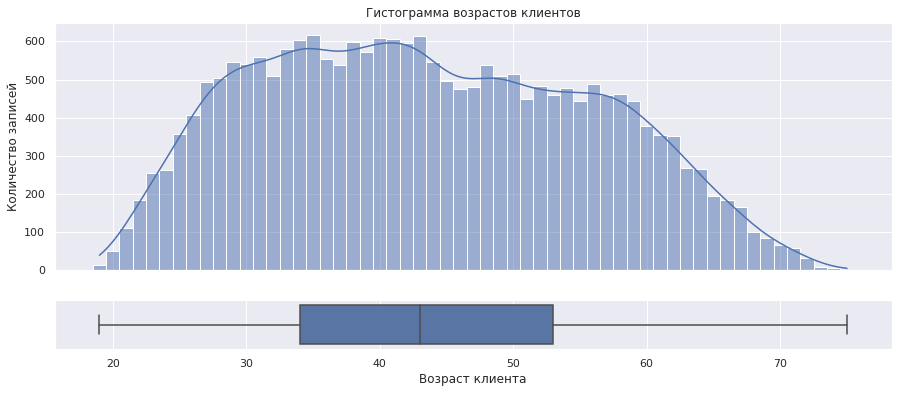

In [122]:
f, [axs_hist, axs_box] = plt.subplots(2, 1,
                                     figsize=(15, 6), 
                                     sharex=True,
                                     gridspec_kw=dict(height_ratios=[5,1]))
sns.histplot(data=df, x='dob_years', discrete=True, kde=True, ax=axs_hist)\
.set(title='Гистограмма возрастов клиентов',
     ylabel='Количество записей')
sns.boxplot(data=df, x='dob_years', ax=axs_box)\
.set(xlabel='Возраст клиента');

#### `education`

In [123]:
df['education'].unique()

array(['высшее', 'среднее', 'Среднее', 'СРЕДНЕЕ', 'ВЫСШЕЕ',
       'неоконченное высшее', 'начальное', 'Высшее',
       'НЕОКОНЧЕННОЕ ВЫСШЕЕ', 'Неоконченное высшее', 'НАЧАЛЬНОЕ',
       'Начальное', 'Ученая степень', 'УЧЕНАЯ СТЕПЕНЬ', 'ученая степень'],
      dtype=object)

Аномалий нет, но видны неявные дубликаты, появившиеся из-за записей в разном регистре.

In [124]:
df['education'] = df['education'].str.lower()
# проверим результат
df['education'].unique()

array(['высшее', 'среднее', 'неоконченное высшее', 'начальное',
       'ученая степень'], dtype=object)

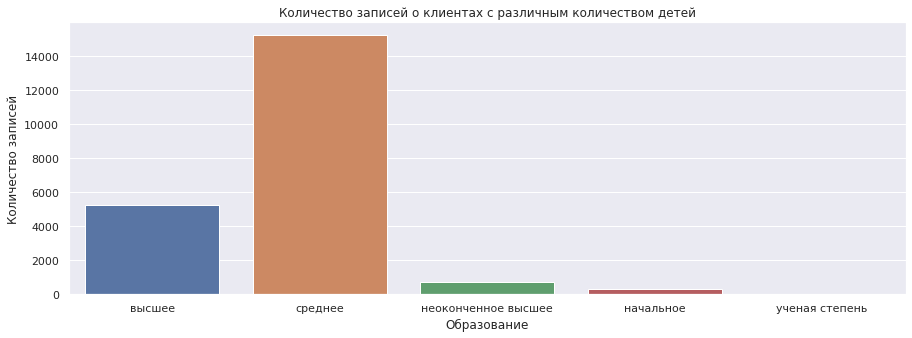

In [125]:
sns.countplot(data=df, x='education')\
.set(title='Количество записей о клиентах с различным количеством детей',
     xlabel='Образование',
     ylabel='Количество записей');

#### `education_id`

In [126]:
df['education_id'].unique()

array([0, 1, 2, 3, 4])

Аномалий нет.

#### `family_status`

In [127]:
df['family_status'].unique()

array(['женат / замужем', 'гражданский брак', 'вдовец / вдова',
       'в разводе', 'Не женат / не замужем'], dtype=object)

Аномалий нет, на всякий случай приведём все записи к нижнему регистру.

In [128]:
df['family_status'] = df['family_status'].str.lower()
# проверим результат
df['family_status'].unique()

array(['женат / замужем', 'гражданский брак', 'вдовец / вдова',
       'в разводе', 'не женат / не замужем'], dtype=object)

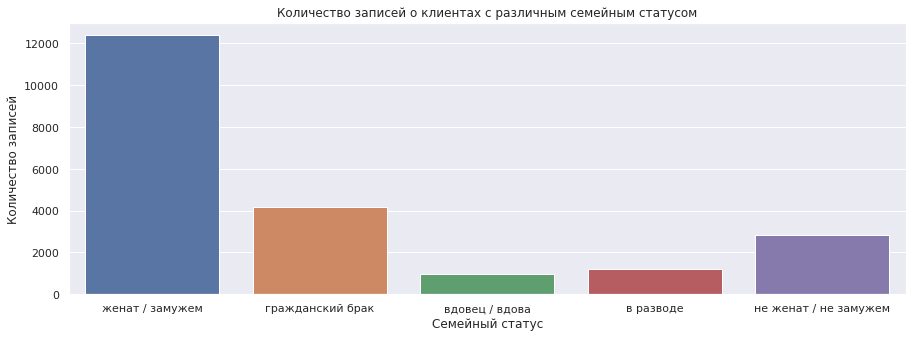

In [129]:
sns.countplot(data=df, x='family_status')\
.set(title='Количество записей о клиентах с различным семейным статусом',
     xlabel='Семейный статус',
     ylabel='Количество записей');

#### `family_status_id`

In [130]:
df['family_status_id'].unique()

array([0, 1, 2, 3, 4])

Аномалий нет.

#### `gender`

In [131]:
df['gender'].unique()

array(['F', 'M', 'XNA'], dtype=object)

In [132]:
df[df['gender'] == 'XNA']['gender'].count()

1

В одной записи указан пол 'XNA'. Возможно это ошибка записи, возможно клиент попросил указать пол именно так. Так как для дальнейшего решения задачи этот столбец нам не важен, можно оставить эту аномалию как есть.

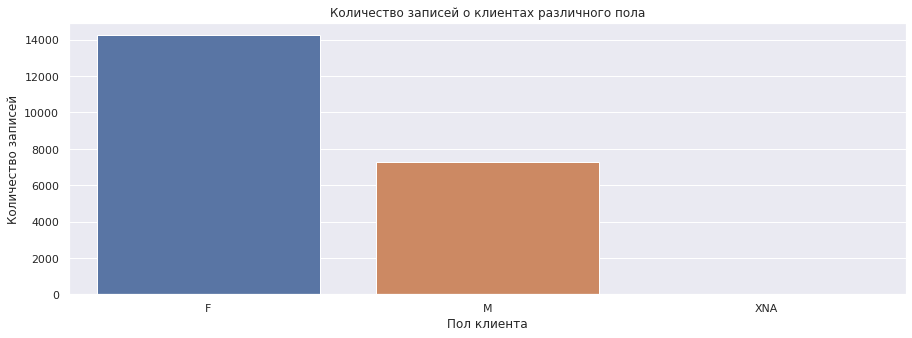

In [133]:
sns.countplot(data=df, x='gender')\
.set(title='Количество записей о клиентах различного пола',
     xlabel='Пол клиента',
     ylabel='Количество записей');

#### `income_type`

In [134]:
df['income_type'].unique()

array(['сотрудник', 'пенсионер', 'компаньон', 'госслужащий',
       'безработный', 'предприниматель', 'студент', 'в декрете'],
      dtype=object)

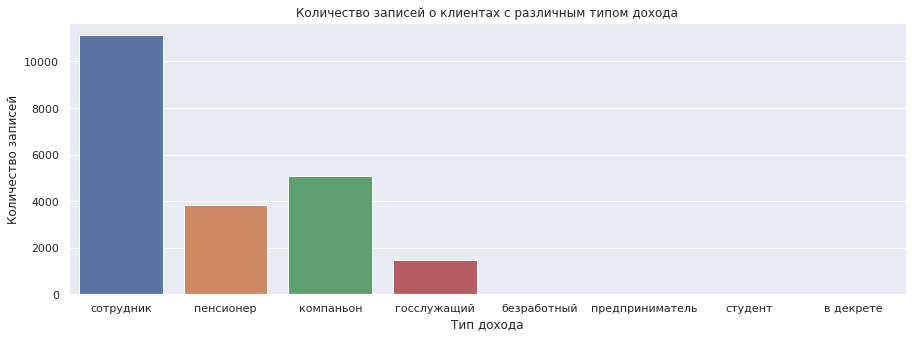

In [135]:
sns.countplot(data=df, x='income_type')\
.set(title='Количество записей о клиентах с различным типом дохода',
     xlabel='Тип дохода',
     ylabel='Количество записей');

Аномалий нет.

#### `debt`

In [136]:
df['debt'].unique()

array([0, 1])

Аномалий нет. 

#### `purpose`

In [137]:
df['purpose'].unique()

array(['покупка жилья', 'приобретение автомобиля',
       'дополнительное образование', 'сыграть свадьбу',
       'операции с жильем', 'образование', 'на проведение свадьбы',
       'покупка жилья для семьи', 'покупка недвижимости',
       'покупка коммерческой недвижимости', 'покупка жилой недвижимости',
       'строительство собственной недвижимости', 'недвижимость',
       'строительство недвижимости', 'на покупку подержанного автомобиля',
       'на покупку своего автомобиля',
       'операции с коммерческой недвижимостью',
       'строительство жилой недвижимости', 'жилье',
       'операции со своей недвижимостью', 'автомобили',
       'заняться образованием', 'сделка с подержанным автомобилем',
       'получение образования', 'автомобиль', 'свадьба',
       'получение дополнительного образования', 'покупка своего жилья',
       'операции с недвижимостью', 'получение высшего образования',
       'свой автомобиль', 'сделка с автомобилем',
       'профильное образование', 'высшее об

Аномалий нет, возможно есть неявные дубликаты, но их мы обработаем на следующем этапе.

### Изменение типов данных

Изменим тип данных колонки `total_income` на _int_ (целочиселнный тип) для удобства дальнейшей обработки.

In [138]:
# изменяем тип данных на целочисленный
try:
    df['total_income'] = df['total_income'].astype(int)
except:
    print('При конвертации возникли проблемы')
# выводим общую информацию о таблице чтобы убедиться, что тип данных успешно изменён
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21525 non-null  int64  
 1   days_employed     19351 non-null  float64
 2   dob_years         21525 non-null  int64  
 3   education         21525 non-null  object 
 4   education_id      21525 non-null  int64  
 5   family_status     21525 non-null  object 
 6   family_status_id  21525 non-null  int64  
 7   gender            21525 non-null  object 
 8   income_type       21525 non-null  object 
 9   debt              21525 non-null  int64  
 10  total_income      21525 non-null  int64  
 11  purpose           21525 non-null  object 
dtypes: float64(1), int64(6), object(5)
memory usage: 2.0+ MB


### Удаление дубликатов

Удалим из таблицы явные дубликаты

In [139]:
print('Количество обнаруженных дупликатов:', df.duplicated().sum())
df = df.drop_duplicates().reset_index(drop=True)
print('Количество дупликатов после чистки:', df.duplicated().sum())

Количество обнаруженных дупликатов: 71
Количество дупликатов после чистки: 0


Мы предварительно удалили неявные дупликаты из столбца `education` на этапе поиска аномалий, поэтому проверка на дупликаты всей таблицы была более эффективной.

Возможные причины появления дупликатов: данные могли объединять из нескольких источников.

### Формирование дополнительных датафреймов словарей, декомпозиция исходного датафрейма

В нашей таблице содержатся пары колонок `education`—`education_id` и `family_status`—`family_status_id`. Выделим эти колонки в отдельные таблицы, оставим в исходной таблице только колонки `education_id` и `family_status_id`. Таким образом будет проще производить дальнейшую обработку данных.

In [140]:
education_dict = df[['education', 'education_id']]
education_dict = education_dict.drop_duplicates().reset_index(drop=True)
print('Словарь по образованию:')
education_dict

Словарь по образованию:


,education,education_id
0,высшее,0
1,среднее,1
2,неоконченное высшее,2
3,начальное,3
4,ученая степень,4


In [141]:
family_status_dict = df[['family_status', 'family_status_id']]
family_status_dict = family_status_dict.drop_duplicates().reset_index(drop=True)
print('Словарь по семейному положению:')
family_status_dict

Словарь по семейному положению:


,family_status,family_status_id
0,женат / замужем,0
1,гражданский брак,1
2,вдовец / вдова,2
3,в разводе,3
4,не женат / не замужем,4


In [142]:
# удаляем столбцы из исходной таблицы
del df['education']
del df['family_status']
# контроль
print(df.columns)

Index(['children', 'days_employed', 'dob_years', 'education_id',
       'family_status_id', 'gender', 'income_type', 'debt', 'total_income',
       'purpose'],
      dtype='object')


### Категоризация дохода

Добавим в таблицу дополнительную колонку `total_income_category`, где каждому заёмщику присвоим категорию в зависимости от уровня его дохода. Заёмщикам с доходом от 0 до 30 000 будет присвоена категория _E_, с доходом от 30 000 до 50 000 — категория _D_, с доходом от 50 000 до 200 000 — категория _C_, с доходом от 200 000 до 1 000 000 — категория _B_, с доходом от 1 000 000 — категория _A_.

In [143]:
df['total_income_category'] = pd.cut(df['total_income'], 
                                     bins=[0, 30000, 50000, 200000, 1000000, df['total_income'].max()], 
                                     labels=['E', 'D', 'C', 'B', 'A'])
# контроль
df['total_income_category'].unique()

['B', 'C', 'D', 'E', 'A']
Categories (5, object): ['E' < 'D' < 'C' < 'B' < 'A']

In [144]:
df.head()

,children,days_employed,dob_years,education_id,family_status_id,gender,income_type,debt,total_income,purpose,total_income_category
0,1,8437.673028,42,0,0,F,сотрудник,0,253875,покупка жилья,B
1,1,4024.803754,36,1,0,F,сотрудник,0,112080,приобретение автомобиля,C
2,0,5623.422610,33,1,0,M,сотрудник,0,145885,покупка жилья,C
3,3,4124.747207,32,1,0,M,сотрудник,0,267628,дополнительное образование,B
4,0,340266.072047,53,1,1,F,пенсионер,0,158616,сыграть свадьбу,C


### Категоризация целей кредита

Категоризируем колонку `purpose_category`. Разделим все цели на четыре категории: _операции с недвижимостью, операции с автомобилем, проведение свадьбы_ и _получение обарзования._

In [145]:
def purpose_category(purpose):
    if 'авто' in purpose:
        return 'операции с автомобилем'
    elif (('недвиж' in purpose) or
          ('жил' in purpose)):
        return 'операции с недвижимостью'
    elif 'свад' in purpose:
        return 'проведение свадьбы'
    elif 'образ' in purpose:
        return 'получение образования'
    else:
        return 'UNDEF' # для контроля

try:
    df['purpose_category'] = df['purpose'].apply(purpose_category)
except:
    print('При категоризации возникли проблемы')
# контроль
df['purpose_category'].unique()

array(['операции с недвижимостью', 'операции с автомобилем',
       'получение образования', 'проведение свадьбы'], dtype=object)

## Анализ данных

### Есть ли зависимость между количеством детей и возвратом кредита в срок?

Чтобы ответить на этот вопрос сгруппируем все записи по количеству детей, а затем для каждой группы просуммируем значения столбца `debt`. Но этого мало, вполне возможно, что количество людей без детей больше, поэтому у них в сумме будет больше случаев задолженности. Чтобы получить процент людей с задолженностью от общего количества людей в категории проведём следующие операции:

In [146]:
# группируем по столбцу и применяем операции 
first_question = df.groupby('children').agg({'debt': ['count', 'mean']})
first_question

debt          
          count      mean
children                 
0         14214  0.075419
1          4808  0.092346
2          2052  0.094542
3           330  0.081818
4            41  0.097561
5             9  0.000000

**Вывод**

Так как данных о клиентах с тремя, четырьмя и пятью детьми относительно мало, можно сосродоточиться на данных о клиентах без детей, с одним ребёнком или двумя детьми. Видно, что среди клиентов с детьми доля тех, кто имеет проблемы с возвратом кредита в срок (9,2—9,4 %), больше, чем среди бездетных клиентов (7,5 %). Зависимость между числом детей и возвратом кредита в срок есть.

### Есть ли зависимость между семейным положением и возвратом кредита в срок? 

Поступим аналогично:

In [147]:
# группируем по столбцу и применяем операции 
second_question = df.groupby('family_status_id').agg({'debt': ['count', 'mean']})
second_question

debt          
                  count      mean
family_status_id                 
0                 12339  0.075452
1                  4151  0.093471
2                   959  0.065693
3                  1195  0.071130
4                  2810  0.097509

In [148]:
# для удобства выведем рядом словарь с family status
family_status_dict

,family_status,family_status_id
0,женат / замужем,0
1,гражданский брак,1
2,вдовец / вдова,2
3,в разводе,3
4,не женат / не замужем,4


**Вывод**

Видно, что не женатые или не замужние клиенты, а также клиенты состоящие в гражданском браке чаще других имеют проблемы с возвратом кредитов в срок (9,7 и 9,3 % соответственно). Меньше всего проблем с возвратом кредитов в срок у вдовцов и вдов (6,5 %), клиентов в разводе (7,1 %) и женатых, замужних клиентов (7,5 %).

### Есть ли зависимость между уровнем дохода и возвратом кредита в срок?

Поступим аналогично:

In [149]:
# группируем по столбцу и применяем операции
third_question = df.groupby('total_income_category')\
.agg({'debt': ['count', 'mean']})\
.sort_values(by='total_income_category', ascending=False)
# считаем процент
third_question

debt          
                       count      mean
total_income_category                 
A                         25  0.080000
B                       5041  0.070621
C                      16016  0.084915
D                        350  0.060000
E                         22  0.090909

**Вывод**

Данных о клиентах с категориями дохода *A, D, E* слишком мало для того, чтобы делать обоснованные выводы. Среди клиентов с категорией дохода *B* меньше доля людей, имеющих проблемы с возвратом кредита в срок, (7 %), чем среди клиентов с категорией дохода *C* (8,4 %).

### Как разные цели кредита влияют на его возврат в срок?

Поступим аналогично:

In [150]:
# группируем по столбцу и применяем операции
forth_question = df.groupby('purpose_category').agg({'debt': ['count', 'mean']})
forth_question

debt          
                          count      mean
purpose_category                         
операции с автомобилем     4306  0.093590
операции с недвижимостью  10811  0.072334
получение образования      4013  0.092200
проведение свадьбы         2324  0.080034

**Вывод**

Видно, что среди людей, берущих кредит на операции с недвижимостью, доля тех, кто имеет проблемы с возратом кредита в срок, ниже (7,2 %), чем у других клиентов. Больше всего проблем с возвратом кредита в срок возникает у клиентов, которые берут его для получения образования (9,2 %) и для совершения операций с автомобилем (9,3 %).

## Общий вывод

Имеются данные о клиентах банка, желающих взять кредит. По имеющимся данным необходимо оценить, влияют ли семейное положение и количество детей клиента на факт погашения кредита в срок.

Результаты исследования могут быть использованы при построении модели кредитного скоринга — системы, которая оценивает способность потенциального заёмщика вернуть кредит банку.

В таблице 21525 строк и 12 колонок. В них содержутся следующие данные:

* `children` — количество детей в семье
* `days_employed` — общий трудовой стаж в днях
* `dob_years` — возраст клиента в годах
* `education` — уровень образования клиента
* `education_id` — идентификатор уровня образования
* `family_status` — семейное положение
* `family_status_id` — идентификатор семейного положения
* `gender` — пол клиента
* `income_type` — тип занятости
* `debt` — имел ли задолженность по возврату кредитов
* `total_income` — ежемесячный доход
* `purpose` — цель получения кредита

После предварительной обработки данных (удаления дубликатов и пропусков) данные о клиентах были сгруппированы по уровням дохода и по целям кредитов.

После анализа обработанных данных удалось выявить зависимость между семейным положением, наличием детей, целью кредита и вероятностью возникновения проблем с возвратом кредита в срок. Было установлено, что меньше всего проблем с возвратом кредита в срок возникает у клиентов без детей, вдовцов или вдов, у клиентов со средним уровнем дохода и у клиентов берущих кредит на операции с недвижимостью.